In [32]:
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras import regularizers

from sklearn.utils import class_weight
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


def integral(y,x,bins):
    x_min=x
    s=0
    for i in np.where(bins>x)[0][:-1]:
#        s=s+y[i]*(bins[i+1]-bins[i])
#        print(i,s)
        s=s+y[i]*(bins[i+1]-bins[i])
    return s

class ROC:
    def __init__(self,MVA_model,X_test_scaled,y_test,MVA_model_name):
#        noise_score_1=MVA_model.predict(X_test_scaled[np.where(y_test==1)])[:,0]
#        noise_score_0=MVA_model.predict(X_test_scaled[np.where(y_test==0)])[:,0]
        signal_score_1=MVA_model.predict(X_test_scaled[np.where(y_test==1)])[:,1]
        signal_score_0=MVA_model.predict(X_test_scaled[np.where(y_test==0)])[:,1]
    
        matplotlib.rc('font', size=12)
        matplotlib.rc('axes', titlesize=12)
        
        Nbins=1000
        bin_range=np.arange(0,Nbins+1)/Nbins
        y_signal,bins_1,_=plt.hist(signal_score_1, bins=bin_range, alpha=1, label='Signal',histtype='step')#, density=True
        y_bkg,bins_0,_=plt.hist(signal_score_0, bins=bin_range, alpha=1, label='Background',histtype='step')#, density=True
        plt.yscale('log')
        plt.legend()
        plt.xlabel('MVA score')
        #plt.savefig(MVA_model_name+'_score.pdf')
        plt.show()

        Nsignal=integral(y_signal,0,bins_1)
        Nbkg=integral(y_bkg,0,bins_0)
        signal_eff=np.array([])
        bkg_eff=np.array([])
        y_s=0
        y_n=0
        for i in range(0,Nbins+1):
            x=i/Nbins
            y_s=integral(y_signal,x,bins_1)/Nsignal
            y_n=integral(y_bkg,x,bins_0)/Nbkg
            signal_eff=np.append(signal_eff,y_s)
            bkg_eff=np.append(bkg_eff,y_n)

        #Area=round(1000*integral(signal_eff,0)/Nbins)/1000
        res=1e5
        Area=round(res*abs(integral(signal_eff,0,bkg_eff)))/res
        
        lab='Area: '+str(Area)
        plt.plot(bkg_eff,signal_eff,label=lab)
        plt.plot([0,1],[0,1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        #plt.xlim([0.001,1])
        #plt.yscale('log')
        plt.title('ROC curve')
        plt.legend()
#        plt.savefig('ROC_'+MVA_model_name+'.pdf')
        plt.show()

        WP=[0.90,0.94,0.97,0.99]
        rej=1./bkg_eff
        WP_idx=[np.where(np.abs(signal_eff-WP[i])==np.min(np.abs(signal_eff-WP[i])))[0][0] for i in range(0,len(WP))]
        #rej[WP_idx]
        WP_rej=[]
        for i in range(0,len(WP)):
          if math.isinf(rej[WP_idx[i]])==False:
            WP_rej+=str(round(10*rej[WP_idx[i]])/10)
          else:
            WP_rej+='inf'

#        WP_rej=[str(round(10*rej[WP_idx[i]])/10) for i in range(0,len(WP))]
        print(WP_rej)

        plt.plot(signal_eff,rej)
        for i in range(0,len(WP)):
            plt.axvline(x=WP[i],color='Red',linestyle='dashed',label='Bkg Rejection @ '+str(WP[i])+' WP: '+WP_rej[i])
        plt.xlabel('Signal efficiency')
        plt.ylabel('Background rejection')
        plt.xlim([0.8,1])
        plt.yscale('log')
        plt.title('ROC curve')
        plt.legend()
#        plt.savefig('rejection_ROC_'+MVA_model_name+'.pdf')
        plt.show()
        
        self.auc=Area
        self.signal_eff=signal_eff
        self.bkg_eff=bkg_eff
        self.bkg_rej=rej
        self.WP=WP
        self.WP_rej=WP_rej
        self.y_sig=y_signal
        self.bins_sig=bins_1
        self.y_bkg=y_bkg
        self.bins_bkg=bins_0
        

In [2]:
print(tf.__version__)

2.7.0


In [3]:
def dense_NN():
    n_c=32
    model = tf.keras.Sequential(
        [
            #tf.keras.layers.Flatten(input_shape=(21, 2)),
            layers.BatchNormalization(
                momentum=0.95, 
                epsilon=0.005,
                beta_initializer=RandomNormal(mean=0.0, stddev=0.05),#was 0.05 
                gamma_initializer=Constant(value=0.9)
            ),
            tf.keras.layers.Dense(n_c, activation='relu'),
            tf.keras.layers.Dense(n_c, activation='relu'),
            tf.keras.layers.Dense(2, activation='softmax')

        ]
    )
    return model

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
!ls -l /content/drive/MyDrive/WQeMS

total 11475
-rw------- 1 root root 11215808 Nov 14 14:51 data.npy
-rw------- 1 root root   534208 Nov 14 14:51 labels.npy


In [24]:
path='/content/drive/MyDrive/WQeMS/'

## Loading & Preprocessing dataset

In [25]:
data=np.load(path+'data.npy')
labels=np.load(path+'labels.npy')

In [26]:
# shape: N pixels, time points, n features (VV, VH)
# labels: flood (1) - not-flood (0)

data.shape, labels.shape

((66760, 21, 2), (66760,))

In [27]:
data,labels=shuffle(data,labels)  

## Train and performance eval of the dense model

In [28]:
test_frac=0.2
X_train, X_test, y_train, y_test = train_test_split(data.reshape(66760,42),labels, test_size=test_frac)

In [29]:
model=dense_NN()

In [30]:
model.compile(loss='categorical_crossentropy',metrics = ['accuracy'])

In [31]:
history=model.fit(X_train, to_categorical(y_train), 
               batch_size=128, 
               epochs=1, 
               verbose=1, 
               #validation_split=0.2,#0.1,  
               #callbacks=[callback], 
               #class_weight=class_weights
              )

418/418 [==============================] - 2s 2ms/step - loss: 0.0652 - accuracy: 0.9832


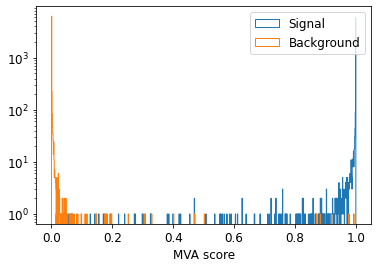

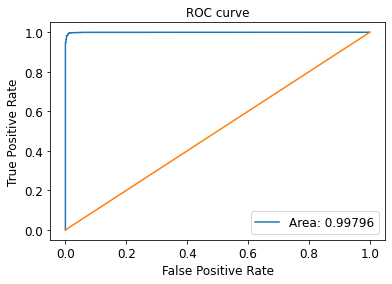

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


OverflowError: ignored

In [33]:
NN_base=ROC(model, X_test, y_test,'NN')

## CNN

In [ ]:
data_shape=data.shape
print(data_shape)

(66760, 21, 2)


In [ ]:
test_frac=0.2
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(data,labels, test_size=test_frac)

In [ ]:
N_FILTERS_PER_FEATURE=1
N_FEATURES=data_shape[2]#2


model = models.Sequential()
#model.add(layers.BatchNormalization(
#                momentum=0.95, 
#                epsilon=0.005,
#                beta_initializer=RandomNormal(mean=0.0, stddev=0.05),#was 0.05 
#                gamma_initializer=Constant(value=0.9)
#            ))
model.add(layers.Conv1D(filters=N_FILTERS_PER_FEATURE*N_FEATURES,
                        kernel_size=3, 
                        activation='relu',
                        groups=N_FEATURES,
                        input_shape=data_shape[1:])
         )
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )


TypeError: ('Keyword argument not understood:', 'groups')

In [ ]:
history = model.fit(X_train_CNN, to_categorical(y_train_CNN), 
                    epochs=10, 
                    verbose=1,
                   )


Train on 53408 samples
Epoch 1/10
53408/53408 [==============================] - 7s 131us/sample - loss: 0.2711 - acc: 0.9131
Epoch 2/10
53408/53408 [==============================] - 7s 123us/sample - loss: 0.0342 - acc: 0.9905
Epoch 3/10
53408/53408 [==============================] - 7s 124us/sample - loss: 0.0267 - acc: 0.9929
Epoch 4/10
53408/53408 [==============================] - 6s 121us/sample - loss: 0.0211 - acc: 0.9946
Epoch 5/10
53408/53408 [==============================] - 6s 122us/sample - loss: 0.0174 - acc: 0.9956
Epoch 6/10
53408/53408 [==============================] - 6s 120us/sample - loss: 0.0147 - acc: 0.9959
Epoch 7/10
53408/53408 [==============================] - 6s 118us/sample - loss: 0.0123 - acc: 0.9966
Epoch 8/10
53408/53408 [==============================] - 6s 120us/sample - loss: 0.0107 - acc: 0.9972
Epoch 9/10
53408/53408 [==============================] - 6s 118us/sample - loss: 0.0094 - acc: 0.9976
Epoch 10/10
53408/53408 [=========================

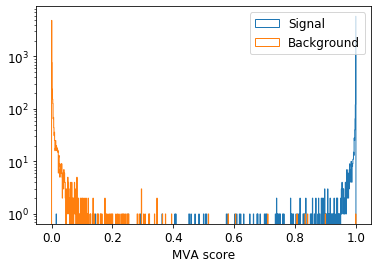

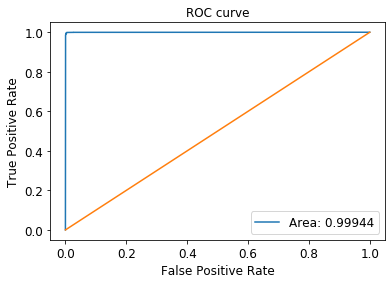

/afs/le.infn.it/user/c/centonze/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


['2059.0', '2059.0', '2059.0', '1029.5']


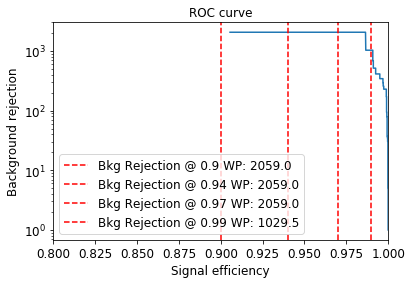

In [ ]:
CNN_model=ROC(model, X_test_CNN, y_test_CNN,'CNN')